In [36]:
import numpy as np
import pandas as pd
from scipy.stats import wasserstein_distance, entropy, skew, kurtosis
from hmmlearn.hmm import GaussianHMM, GMMHMM
import matplotlib.pyplot as plt
import yfinance as yf

In [50]:
def get_sp500_data(start_date, end_date):
    sp500 = yf.download('^GSPC', start=start_date, end=end_date)
    return sp500['Adj Close']

def compute_features(base, window):
    q75, q25 = np.percentile(base, [75, 25])
    iqr = q75 - q25
    bin_width = 2 * iqr * len(base) ** (-1/3)
    bins = int(np.ceil((base.max() - base.min()) / bin_width))

    hist_base, bin_edges = np.histogram(base, bins=bins, density=True)
    hist_window, _ = np.histogram(window, bins=bin_edges, density=True)

    emd = wasserstein_distance(hist_base, hist_window)
    KL1 = entropy(hist_window + 1e-10, hist_base + 1e-10)
    KL2 = entropy(hist_base + 1e-10, hist_window + 1e-10)

    mean = np.mean(window)
    std_dev = np.std(window)
    skewness = skew(window)
    kurt = kurtosis(window)
    max_val = np.max(window)
    min_val = np.min(window)
    median = np.median(window)

    feature_vector = np.array([
        emd, KL1, KL2, mean, std_dev, skewness, kurt, max_val, min_val, median,
    ])
    
    return feature_vector

def calculate_features(data, window_size=30):
    features = []
    for i in range(window_size, len(data)):
        window = data[i-window_size:i]
        base = data[:i]
        feature_set = compute_features(base, window)
        features.append(feature_set)
    return np.array(features)

def apply_hmm(features, n_states=3, covariance_type='diag', n_iter=10000):
    model = GaussianHMM(n_components=n_states, covariance_type=covariance_type, n_iter=n_iter)
    model.fit(features)
    hidden_states = model.predict(features)
    return hidden_states, model

# Function to apply GMMHMM
def apply_gmmhmm(features, n_states=3, n_mix=3, covariance_type='full', n_iter=10000):
    model = GMMHMM(n_components=n_states, n_mix=n_mix, covariance_type=covariance_type, n_iter=n_iter)
    model.fit(features)
    hidden_states = model.predict(features)
    return hidden_states, model

def visualize_market_states(data, states, n_states, window_size):
    data = data[window_size:]
    state_labels = {i: f'State {i}' for i in range(n_states)}
    colors = {i: plt.cm.tab10.colors[i] for i in range(n_states)}

    plt.figure(figsize=(15, 7))

    for state in np.unique(states):
        idx = (states == state)
        # Plot only continuous segments for each state to avoid overlapping lines
        plt.plot(data.index[idx], data[idx], '.', label=state_labels[state], color=colors[state])

    plt.title(f'Market States based on HMM with {n_states} States', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('S&P 500 Index Return Value', fontsize=14)
    plt.legend(title="Market States", fontsize=12)
    plt.grid(True)
    plt.show()

def visualize_market_states_index(data, states, title="Market States based on HMM"):
    plt.figure(figsize=(15, 7))
    
    colors = plt.cm.tab10.colors
    for state in np.unique(states):
        mask = (states == state)
        plt.plot(data.index[mask], data[mask], '.', color=colors[state], label=f'State {state}')
    
    plt.title(title, fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('S&P 500 Index Value', fontsize=14)
    plt.legend(title="Market States", fontsize=12)
    plt.grid(True)
    plt.show()


In [3]:
start_date = '1990-01-01'
end_date = '2024-08-26'
sp500_data = get_sp500_data(start_date, end_date)

[*********************100%***********************]  1 of 1 completed


In [4]:
data = np.log(sp500_data / sp500_data.shift(1)).dropna()

Log Likelihood on Test Data: 12288.644518990051
Training Data States Visualization


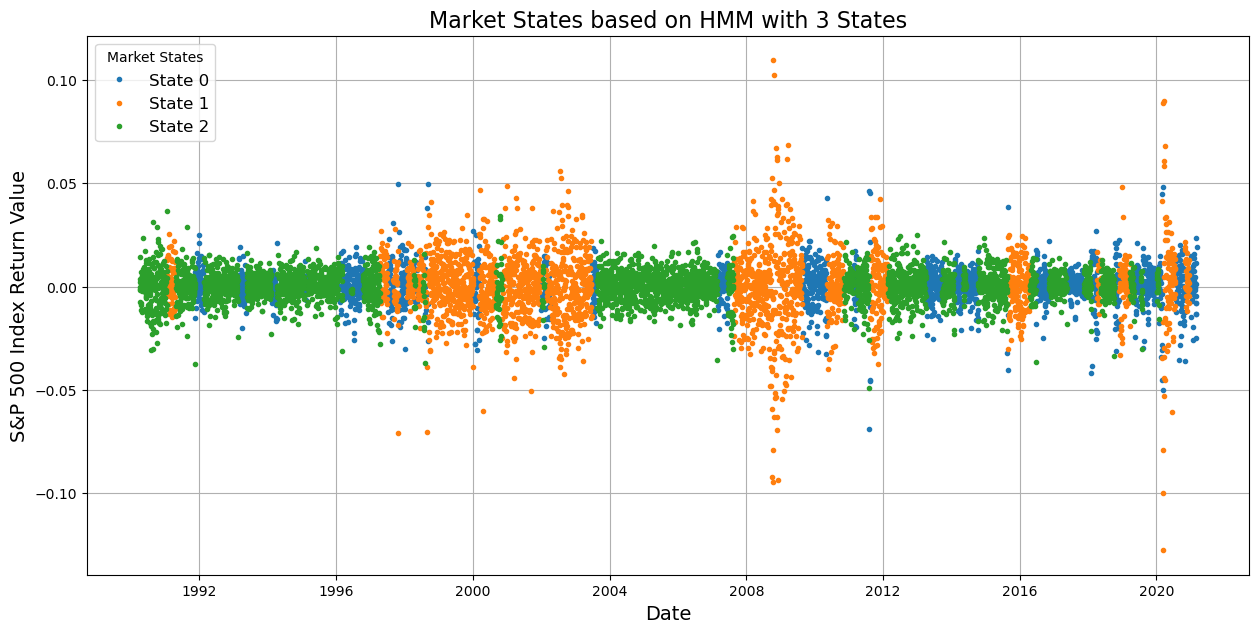

Test Data States Visualization


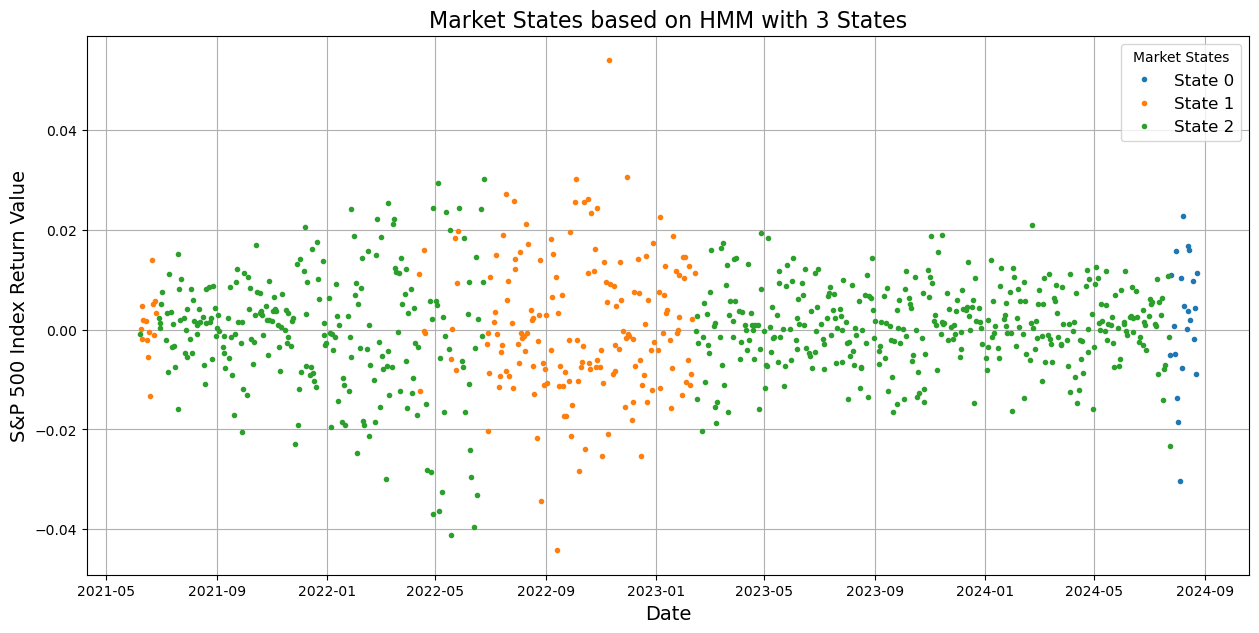

In [62]:
split_point = int(len(data) * 0.9)
train_data = data[:split_point]
test_data = data[split_point:]

window_size = 252//4
train_features = calculate_features(train_data.values, window_size)
test_features = calculate_features(test_data.values, window_size)

# Apply HMM on training data
n_states = 3  # Number of hidden states

hmm_model = GaussianHMM(n_components=n_states, covariance_type='full', n_iter=10000)
hmm_model.fit(train_features)
train_states = hmm_model.predict(train_features)


# predicts next day states
# but the label is the end of the current day
test_states = hmm_model.predict(test_features)

# Evaluate log likelihood on test data
log_likelihood = hmm_model.score(test_features)
print(f'Log Likelihood on Test Data: {log_likelihood}')

# Visualize results for training and test data
print("Training Data States Visualization")
visualize_market_states(train_data, train_states, n_states, window_size)

print("Test Data States Visualization")
visualize_market_states(test_data, test_states, n_states, window_size)

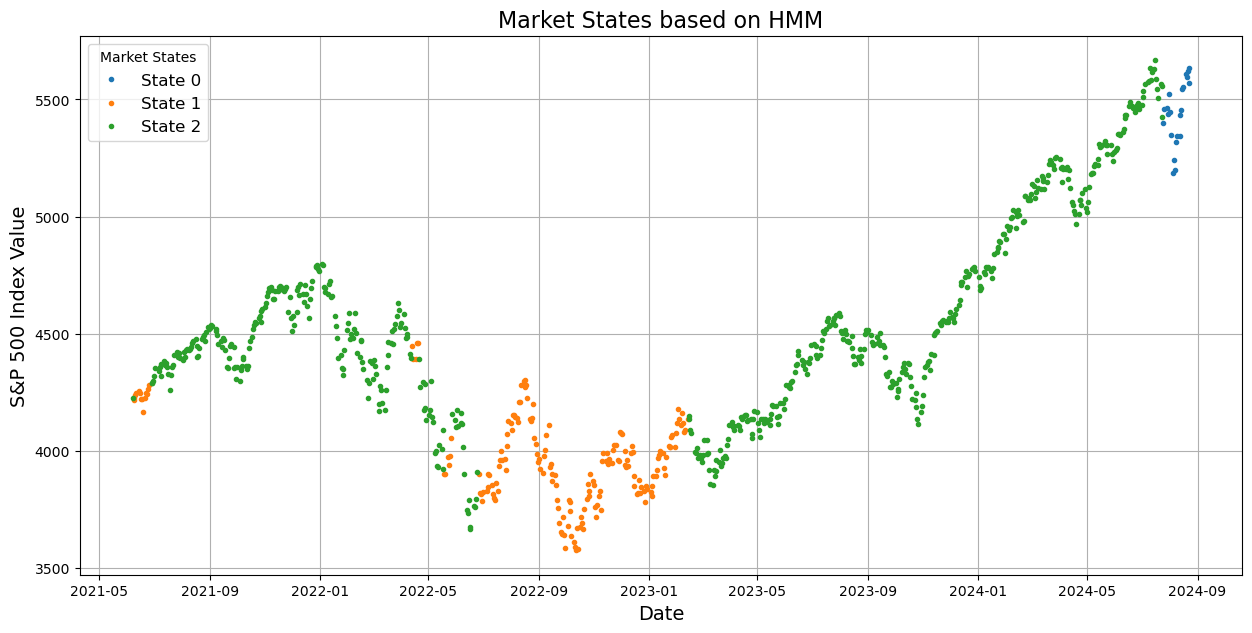

In [64]:
visualize_market_states_index(sp500_data[split_point+window_size+1:], test_states)


- The blue one seems to indicate a transition state